In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import svm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input,Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model,save_model
import zipfile
from shutil import copyfile

## Visualizing dataset

### Import training dataset

In [5]:
img_path = "archive/Face Mask Dataset/Train/"

In [6]:
lable=['yes','no']

In [7]:
img_list = []
label_list = []
for label in lable:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)
        
df_train= pd.DataFrame({'img':img_list, 'label':label_list})

In [8]:
df_train.tail()

,img,label
9995,archive/Face Mask Dataset/Train/no/518.png,no
9996,archive/Face Mask Dataset/Train/no/1853.png,no
9997,archive/Face Mask Dataset/Train/no/4619.png,no
9998,archive/Face Mask Dataset/Train/no/903.png,no
9999,archive/Face Mask Dataset/Train/no/2610.png,no


In [9]:
df_train['label'].value_counts()

yes    5000
no     5000
Name: label, dtype: int64

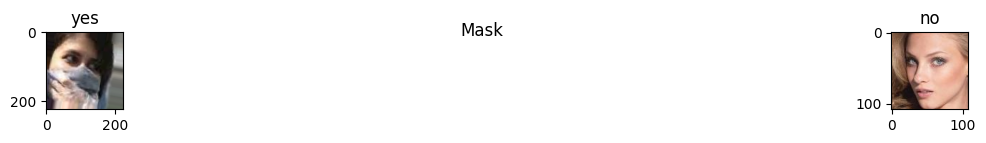

In [10]:
fig, ax = plt.subplots(ncols=len(lable), figsize=(20,1))
fig.suptitle('Mask')
random_num = 12
for i,label in enumerate(lable):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df_train[df_train['label']==label]['img'].iloc[random_num]))

## Validation dataset

In [11]:
img_path_v = "archive/Face Mask Dataset/Validation/"

In [12]:
lable=['yes','no']

In [13]:
img_list = []
label_list = []
for label in lable:
    for img_file in os.listdir(img_path_v+label):
        img_list.append(img_path_v+label+'/'+img_file)
        label_list.append(label)
        
df_val= pd.DataFrame({'img':img_list, 'label':label_list})

## Test dataset 

In [14]:
img_path_t = "archive/Face Mask Dataset/Test/"

In [15]:
lable=['yes','no']

In [16]:
img_list = []
label_list = []
for label in lable:
    for img_file in os.listdir(img_path_t+label):
        img_list.append(img_path_t+label+'/'+img_file)
        label_list.append(label)
        
df_test= pd.DataFrame({'img':img_list, 'label':label_list})

## Training and validation dataset

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)


In [18]:
train_generator = train_datagen.flow_from_dataframe(dataframe= df_train,x_col="img",y_col="label",target_size=(128,128))

Found 10000 validated image filenames belonging to 2 classes.


In [19]:
valid_generator = train_datagen.flow_from_dataframe(dataframe= df_val,x_col="img",y_col="label",target_size=(128,128))

Found 800 validated image filenames belonging to 2 classes.


In [20]:
test_generator = train_datagen.flow_from_dataframe(dataframe= df_test,x_col="img",y_col="label",target_size=(128,128))

Found 992 validated image filenames belonging to 2 classes.


In [21]:
test_generator.class_indices

{'no': 0, 'yes': 1}

In [58]:
classes=list(train_generator.class_indices.keys())
print (classes)

['no', 'yes']


In [22]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)

    print('labels batch shape:', labels_batch.shape)

    break

data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 2)


# Building a model

In [23]:
from keras import layers
from keras import models

In [26]:
input_shape = (128,128,3)
input_image = Input(shape=input_shape)
cnn_model = Conv2D(16, (3, 3), activation='relu', input_shape=input_shape)(input_image)
cnn_model = MaxPool2D((2, 2))(cnn_model)
cnn_model = Conv2D(32, (3, 3), activation='relu')(cnn_model)
cnn_model = MaxPool2D((2, 2))(cnn_model)
cnn_model = Conv2D(64, (3, 3), activation='relu',)(cnn_model)
cnn_model = MaxPool2D((2, 2))(cnn_model)
cnn_model = Conv2D(128, (3, 3), activation='relu')(cnn_model)
cnn_model = MaxPool2D((2, 2))(cnn_model)
cnn_model = Flatten()(cnn_model)
cnn_model = Dense(1024)(cnn_model)
output= Dense(2, activation='softmax')(cnn_model)
cnn_model = Model(inputs=[input_image], outputs=[output])


In [27]:
cnn_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        1849

In [28]:
cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = cnn_model.fit(train_generator, epochs=5,
validation_data=(valid_generator))

Epoch 1/5
313/313 [==============================] - 382s 1s/step - loss: 0.1913 - accuracy: 0.9278 - val_loss: 0.0472 - val_accuracy: 0.9837
Epoch 2/5
313/313 [==============================] - 247s 788ms/step - loss: 0.0507 - accuracy: 0.9831 - val_loss: 0.0229 - val_accuracy: 0.9937
Epoch 3/5
313/313 [==============================] - 237s 757ms/step - loss: 0.0379 - accuracy: 0.9862 - val_loss: 0.0135 - val_accuracy: 0.9950
Epoch 4/5
313/313 [==============================] - 238s 760ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0329 - val_accuracy: 0.9875
Epoch 5/5
313/313 [==============================] - 237s 758ms/step - loss: 0.0310 - accuracy: 0.9890 - val_loss: 0.0199 - val_accuracy: 0.9862


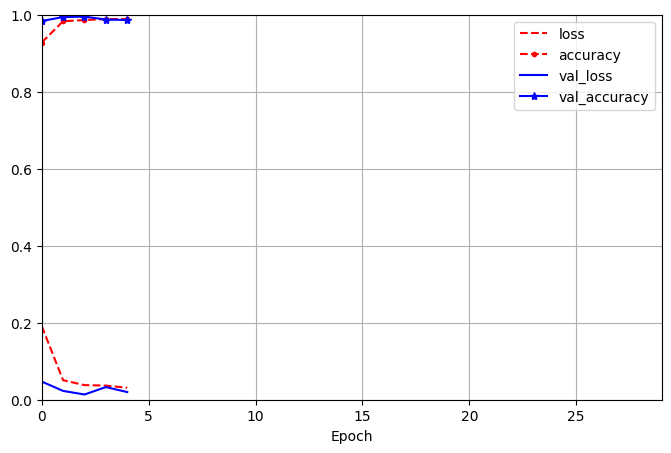

In [30]:
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True,
xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [37]:
cnn_model.save("network.h5")

In [116]:
filepath = 'Sequentional'
save_model(cnn_model, filepath)

# Using data augmentation

In [118]:
train_datagen_A = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [119]:
test_datagen_A = ImageDataGenerator(rescale=1./255)

In [120]:
train_generator = train_datagen_A.flow_from_dataframe(dataframe= df_train,x_col="img",y_col="label",target_size=(128,128))

Found 10000 validated image filenames belonging to 2 classes.


In [121]:
valid_generator_A = test_datagen_A.flow_from_dataframe(dataframe= df_val,x_col="img",y_col="label",target_size=(128,128))

Found 800 validated image filenames belonging to 2 classes.


In [125]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [126]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 14, 14, 128)     

In [127]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
history = cnn_model.fit_generator(train_generator_A, epochs=5,
validation_data=(valid_generator_A))

Epoch 1/5
313/313 [==============================] - 455s 1s/step - loss: 0.1716 - accuracy: 0.9356 - val_loss: 0.1622 - val_accuracy: 0.9425
Epoch 2/5
313/313 [==============================] - 399s 1s/step - loss: 0.1368 - accuracy: 0.9486 - val_loss: 0.1041 - val_accuracy: 0.9600
Epoch 3/5
313/313 [==============================] - 241s 749ms/step - loss: 0.1136 - accuracy: 0.9599 - val_loss: 0.0865 - val_accuracy: 0.9650
Epoch 4/5
313/313 [==============================] - 220s 702ms/step - loss: 0.1070 - accuracy: 0.9616 - val_loss: 0.0948 - val_accuracy: 0.9712
Epoch 5/5
313/313 [==============================] - 219s 699ms/step - loss: 0.0925 - accuracy: 0.9673 - val_loss: 0.1257 - val_accuracy: 0.9450
